In [5]:
#importing important libraries
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from scipy.stats import skew
from sklearn.model_selection import train_test_split

In [6]:
#HELPER FUNCTIONS FOR PREPROCESSING DATA

def replaceNullValAppropriately(dataset):
    skewed_cols = []
    non_skewed_cols = []
    for col in dataset.columns:
        if col=='RainToday':
            continue
        if abs(skew(dataset[col].dropna())) > 1.0:
            skewed_cols.append(col)
        else:
            non_skewed_cols.append(col)

    if 'RainToday' in skewed_cols:
        skewed_cols.remove('RainToday')
    if 'RainToday' in non_skewed_cols:
        non_skewed_cols.remove('RainToday')
    # dataset['RainToday'] = [None if math.isnan(x) else x for x in dataset['RainToday']]
    dataset[skewed_cols] = dataset[skewed_cols].fillna(dataset[skewed_cols].median())
    dataset[non_skewed_cols] = dataset[non_skewed_cols].fillna(dataset[non_skewed_cols].mean())
    
    return dataset

In [14]:
# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

def return_int_columns(dataset):
    selected_columns = []
    for column in dataset.columns:
        if not dataset[column].apply(lambda x: isinstance(x, str)).any():
            selected_columns.append(column)
    return dataset[selected_columns]

def check_missing_value(dataset):
    # Show the summary statistics of the dataset
    summary_stats = dataset.describe().transpose()
    print("Summary Statistics:")
    print(tabulate(summary_stats, headers="keys", tablefmt="psql"))
    print()
    
    # Show the number of missing values for each column in the dataset
    missing_values = dataset.isnull().sum().to_frame(name="Missing Values")
    print("Missing Values:")
    print(tabulate(missing_values, headers="keys", tablefmt="psql"))

def calculate_spearman_corr(dataset, target_variable):
    # This function calculates the Spearman correlation between each variable and the target variable.
    df_corr = pd.DataFrame({'features': dataset.columns})
    df_corr['spearman'] = [dataset[c].corr(dataset[target_variable], method='spearman') for c in dataset.columns]
    df_corr = df_corr.sort_values('spearman')
    return df_corr

def plot_spearman_corr(df_corr):
    # This function plots the Spearman correlation for each variable.
    plt.figure(figsize=(6, 0.25 * len(df_corr)))
    sns.barplot(data=df_corr, y='features', x='spearman', orient='h')
    plt.show()

def spearman_corr(dataset):
    # This function analyzes the Spearman correlation between each variable and three different target variables.
    target_variables = ['Rainfall']
    for target_variable in target_variables:
        df_corr = calculate_spearman_corr(dataset, target_variable)
        plot_spearman_corr(df_corr)

def pearson_corr_heatmap(dataset):
    """
    This function is used to analyze the pearson correlation between each variable including the target variable.
    Generally to reduce confounding, only variables uncorrelated with each other should be added to regression models.
    """

    correlation_matrix = dataset.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('pearson_corr_heatmap.png', bbox_inches='tight')
    plt.show()

def convert_wind_direction(dataset):
    directions = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Apply the conversion using map()
    dataset['WindGustDir_num'] = dataset['WindGustDir'].map(directions)
    dataset['WindDir9am_num'] = dataset['WindDir9am'].map(directions)
    dataset['WindDir3pm_num'] = dataset['WindDir3pm'].map(directions)
    dataset['RainTodayNum'] = dataset['RainToday'].str.lower().map({'yes': 1, 'no': 0})
    dataset['RainTomorrowNum'] = dataset['RainTomorrow'].str.lower().map({'yes': 1, 'no': 0})
    dataset['location_encoded'], _ = pd.factorize(dataset['Location'])
    
    return dataset



In [4]:
# STATISTICAL DATA VIEW

data_visualize = pd.read_csv('weatherAUS.csv')
check_missing_value(data_visualize)

Summary Statistics:
+---------------+---------+------------+----------+-------+--------+--------+--------+--------+
|               |   count |       mean |      std |   min |    25% |    50% |    75% |    max |
|---------------+---------+------------+----------+-------+--------+--------+--------+--------|
| MinTemp       |  143975 |   12.194   |  6.39849 |  -8.5 |    7.6 |   12   |   16.9 |   33.9 |
| MaxTemp       |  144199 |   23.2213  |  7.11905 |  -4.8 |   17.9 |   22.6 |   28.2 |   48.1 |
| Rainfall      |  142199 |    2.36092 |  8.47806 |   0   |    0   |    0   |    0.8 |  371   |
| Evaporation   |   82670 |    5.46823 |  4.1937  |   0   |    2.6 |    4.8 |    7.4 |  145   |
| Sunshine      |   75625 |    7.61118 |  3.78548 |   0   |    4.8 |    8.4 |   10.6 |   14.5 |
| WindGustSpeed |  135197 |   40.0352  | 13.6071  |   6   |   31   |   39   |   48   |  135   |
| WindSpeed9am  |  143693 |   14.0434  |  8.91538 |   0   |    7   |   13   |   19   |  130   |
| WindSpeed3pm  |  1

### MANIPULATE WIND DIRECTION TO INT FOR THE FETURE ENGINEERING

In [17]:
actual_data = data_visualize
data_visualize = convert_wind_direction(data_visualize)

In [6]:
data_visualize = return_int_columns(data_visualize)

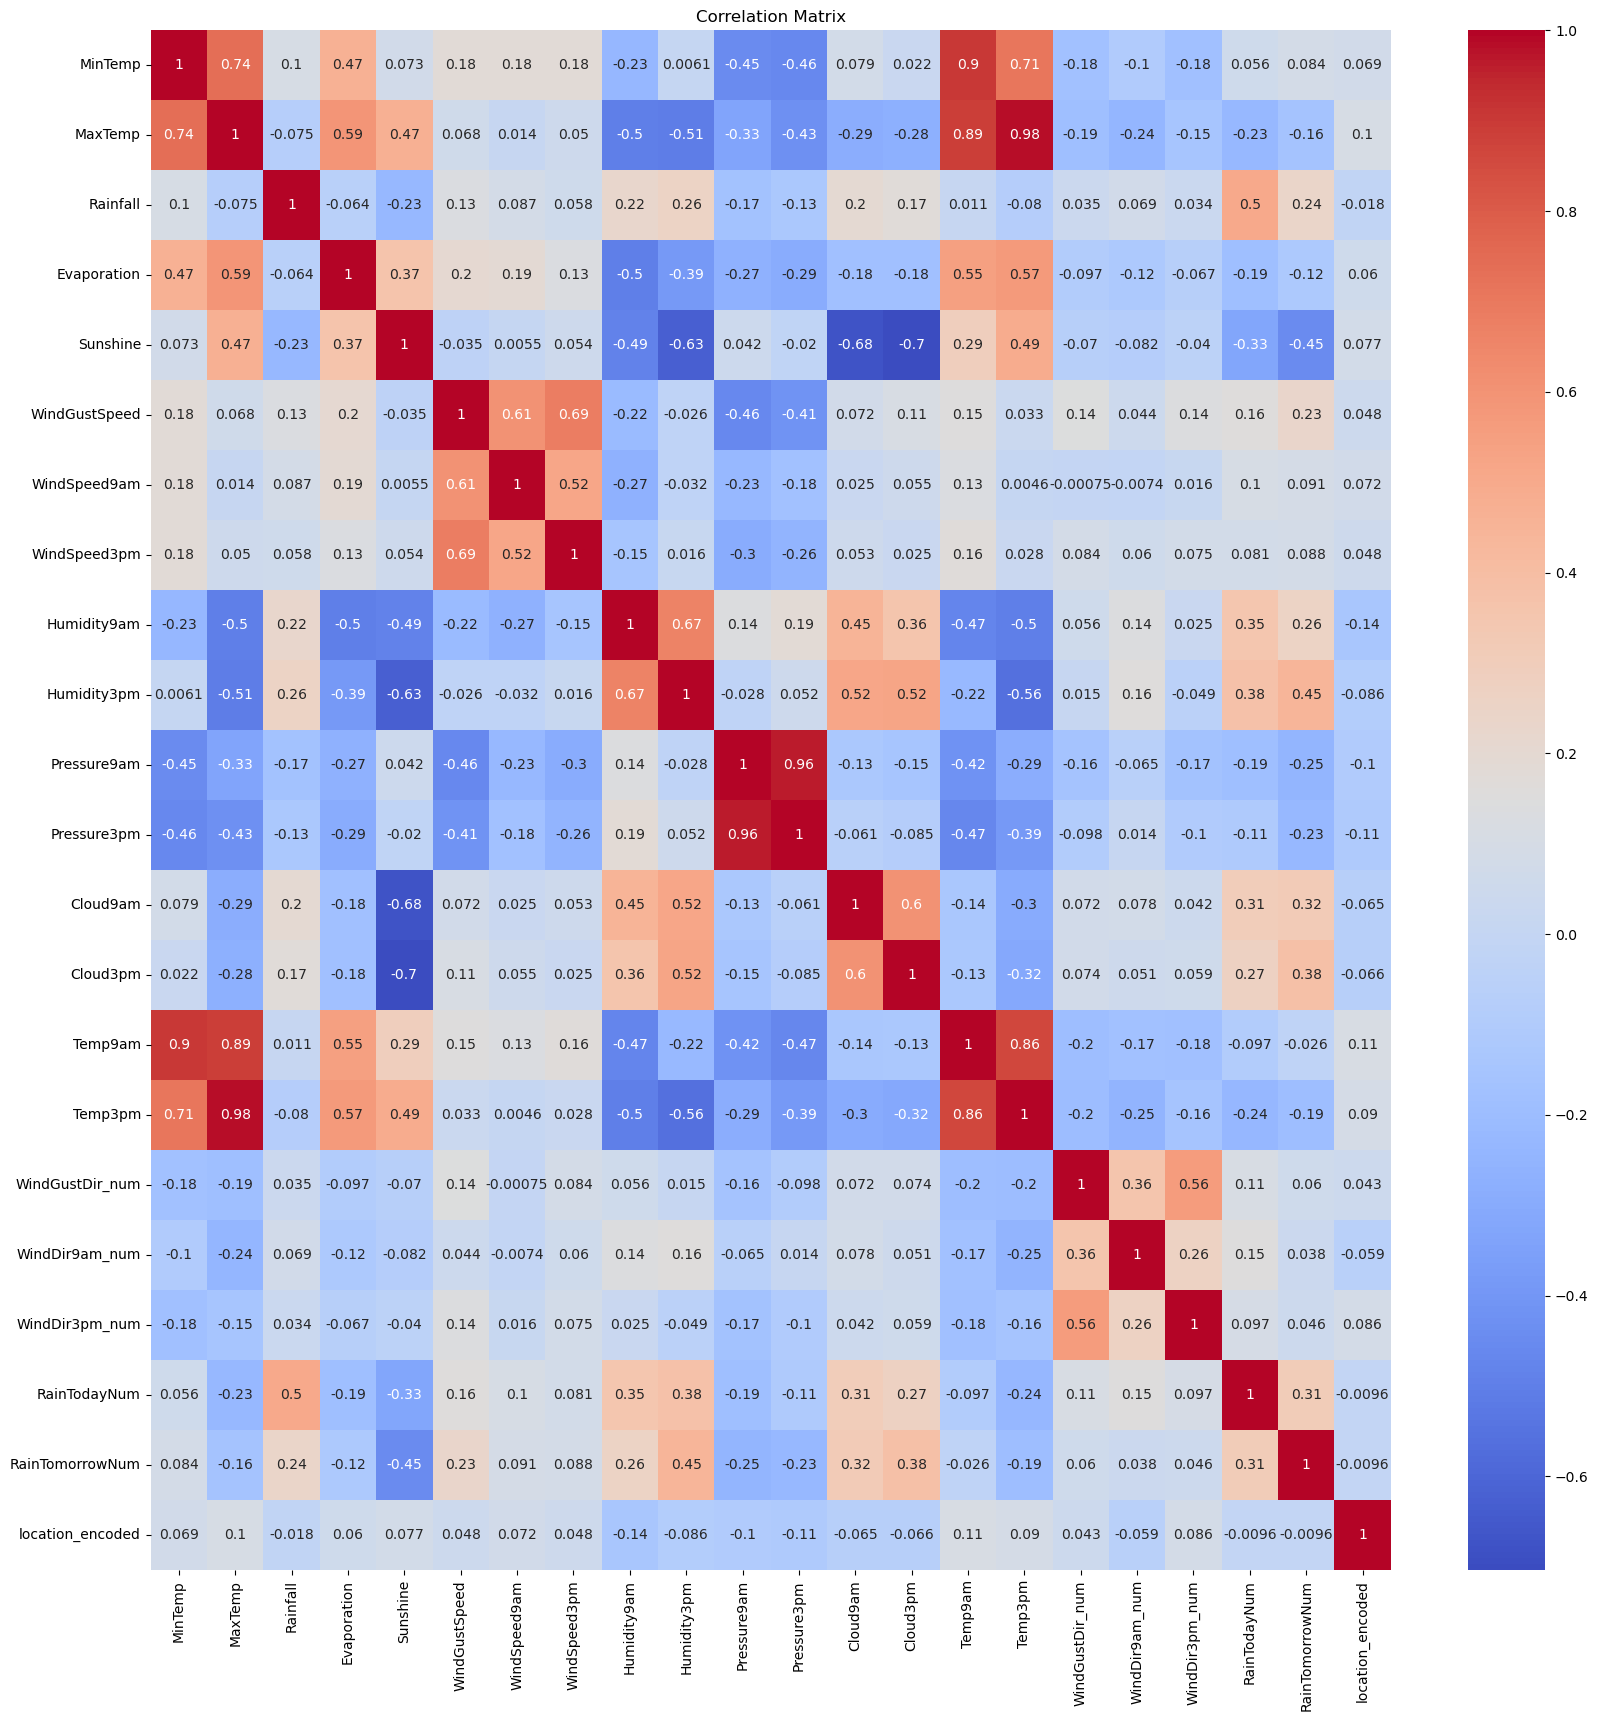

In [7]:
pearson_corr_heatmap(data_visualize)

**Spearman corelation**

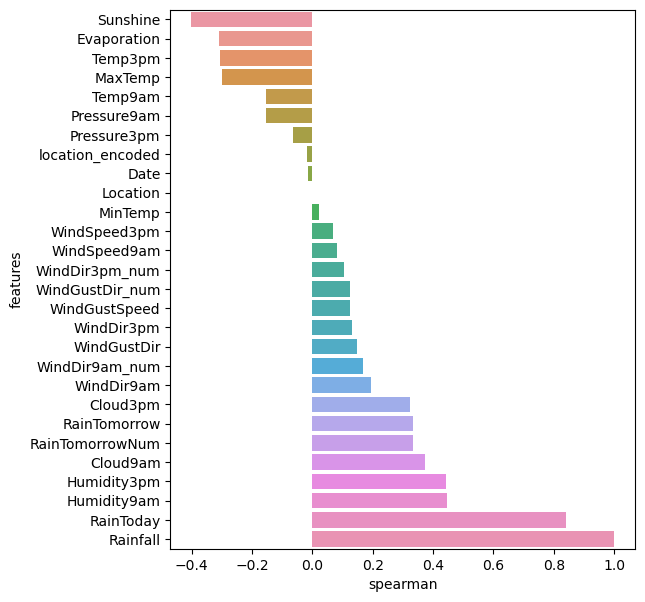

In [8]:
lis = actual_data.columns
lis = lis.delete(lis.get_loc('RainTodayNum'))
spearman_corr(actual_data[lis])

**Data loading, preprocessing, splitting and preparation for modeling.**

In [9]:
# Define a list of column names to select from the dataset
lis = ['Cloud3pm', 'Cloud9am','Humidity9am', 'Humidity3pm','Sunshine','Evaporation','Rainfall','RainToday']
data = actual_data[lis]
# Split the preprocessed data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)
# # MISSING DATA HANDLING AND NULL VALUE REPLACEMENT
handled_train_data = replaceNullValAppropriately(train_df)
handled_test_data = replaceNullValAppropriately(test_df)
handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill() 

In [10]:
# CHECKING THE LENGTH OF SPLIT DATA
print(len(train_df))
print(len(test_df))
print(train_df['RainToday'])

101822
43638
141565     No
85325      No
17847     Yes
69746     Yes
98356     Yes
         ... 
110268     No
119879     No
103694     No
131932     No
121958     No
Name: RainToday, Length: 101822, dtype: object


### ***Decision Tree Classification model***

In [11]:
## imports for the decision tree

import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [12]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

dt_classifier_with_parameters = DecisionTreeClassifier()
dt_classifier_with_parameters.fit(handled_train_data.iloc[:, :-1], handled_train_data['RainToday'])
# Get the column names of the training data
y_pred = dt_classifier_with_parameters.predict(handled_test_data.iloc[:, :-1])
# Creating predicted column to compare
handled_test_data['RainToday_pred'] = y_pred


In [13]:
# Calculate accuracy
accuracy = (handled_test_data['RainToday'] == handled_test_data['RainToday_pred']).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9747009487144233


In [14]:
# Define a list of column names to select from the dataset
lis = ['Cloud3pm', 'Cloud9am','Humidity9am', 'Humidity3pm','Sunshine','Evaporation','Rainfall','RainToday']
data = actual_data[lis]
# Split the preprocessed data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)
# # MISSING DATA HANDLING AND NULL VALUE REPLACEMENT
handled_train_data = replaceNullValAppropriately(train_df)
handled_test_data = replaceNullValAppropriately(test_df)
handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill() 

In [15]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Separate features and target in the training data
X = handled_train_data.iloc[:, :-1]
y = handled_train_data['RainToday']

# Create an instance of the decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# Perform grid search with cross-validation
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create an instance of the decision tree classifier with the best hyperparameters
dt_classifier_best = DecisionTreeClassifier(**best_params)

# Perform k-fold cross-validation
k = 5  # Define the number of folds
scores = cross_val_score(dt_classifier_best, X, y, cv=k, scoring='accuracy')

# Calculate the mean accuracy score
mean_accuracy = scores.mean()
print("Mean Accuracy Score:", mean_accuracy)

# Fit the classifier on the entire training data
dt_classifier_best.fit(X, y)

# Make predictions on the test data
y_pred = dt_classifier_best.predict(handled_test_data.iloc[:, :-1])

# Add predicted column to the test data
handled_test_data['RainToday_pred'] = y_pred


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Accuracy Score: 0.9950600012741345


In [15]:
# Define a list of column names to select from the dataset
lis = ['Cloud3pm', 'Cloud9am','Humidity9am', 'Humidity3pm','Sunshine','Evaporation','Rainfall','RainToday']
data = actual_data[lis]
# Split the preprocessed data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)
# # MISSING DATA HANDLING AND NULL VALUE REPLACEMENT
handled_train_data = replaceNullValAppropriately(train_df)
handled_test_data = replaceNullValAppropriately(test_df)
handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill() 

### ***Semi-supervised Learning with Decision Trees***

In [18]:
#semi-supervised
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def split_data(dataset):
    train_df, test_df = train_test_split(dataset, test_size=0.15, random_state=42)
    handled_train_data = replaceNullValAppropriately(train_df)
    handled_test_data = replaceNullValAppropriately(test_df)
    handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill()
    return handled_train_data
    

desired_accuracy = 0.974
current_accuracy_total = 0
iteration = 0

lis = ['Cloud3pm', 'Cloud9am', 'Humidity9am', 'Humidity3pm', 'Sunshine', 'Evaporation', 'Rainfall', 'RainToday']
data = actual_data[lis]
train_df, test_df = train_test_split(data, test_size=0.15, random_state=42)
handled_train_data = replaceNullValAppropriately(train_df)
handled_test_data = replaceNullValAppropriately(test_df)
handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill()
trained_data = handled_train_data
# trained_data = split_data(data)

while current_accuracy_total < desired_accuracy:
    
    #replace = False, is to get 20% unique labelled data everytime from trained data set
    labeled_idx = np.random.choice(len(trained_data), size=int(len(trained_data) * 0.2),replace=False)
    labeled_data = trained_data.iloc[labeled_idx]
    
    # Get unlabeled data
    unlabeled_idx = np.setdiff1d(np.arange(len(trained_data)), labeled_idx)
    unlabeled_data = trained_data.iloc[unlabeled_idx]
    
    # Train a supervised learning model on the labeled data
    dt_classifier = DecisionTreeClassifier()
    
    # Fit the model on the labeled data
    dt_classifier.fit(labeled_data.iloc[:, :-1], labeled_data['RainToday'])
    
    # Use the trained model to predict the labels for the unlabeled data
    pseudo_labels = dt_classifier.predict(unlabeled_data.iloc[:, :-1])
    
    # Check the probability estimates of the model on the unlabeled data
    probas = dt_classifier.predict_proba(unlabeled_data.iloc[:, :-1])
    high_confidence_idx = np.where(np.max(probas, axis=1) >= 0.85)[0]
    high_confidence_labels = pseudo_labels[high_confidence_idx]
    high_confidence_data = unlabeled_data.iloc[high_confidence_idx, :-1]
    
    # Mix the labeled data with the high-confidence pseudo-labeled data and retrain the model
    mixed_labeled_data = pd.concat([labeled_data.iloc[:, :-1], high_confidence_data])
    mixed_labels = np.concatenate([labeled_data['RainToday'], high_confidence_labels])
    dt_classifier.fit(mixed_labeled_data, mixed_labels)
    # Make predictions on the testing data
    y_pred = dt_classifier.predict(handled_test_data.iloc[:, :-1])
    current_accuracy = (handled_test_data['RainToday'] == y_pred).mean()
    iteration += 1
    print(f"Iteration {iteration}: Accuracy = {current_accuracy}")
#     print(type(current_accuracy),type(desired_accuracy))
    current_accuracy_total = current_accuracy
    
    #now trained data will be labelled and psuedo labeled data
    mixed_labels_df = pd.DataFrame(mixed_labels, columns=['RainToday'])
    mixed_labeled_data['RainToday'] = mixed_labels_df['RainToday'].values
    trained_data = mixed_labeled_data.dropna()
#     print(trained_data)
    # spliting the data set to avoid overfitting
    trained_data = split_data(trained_data)
    
    
print(f"Desired accuracy {desired_accuracy} achieved!")
# Creating a predicted column to compare
handled_test_data['RainToday_pred'] = y_pred

Iteration 1: Accuracy = 0.9736926531921719
Iteration 2: Accuracy = 0.9739218112654109
Iteration 3: Accuracy = 0.9728218525138641
Iteration 4: Accuracy = 0.9722260415234428
Iteration 5: Accuracy = 0.9710802511572483
Iteration 6: Accuracy = 0.9708969246986572
Iteration 7: Accuracy = 0.9700261240203493
Iteration 8: Accuracy = 0.9706219350107704
Iteration 9: Accuracy = 0.9705302717814749
Iteration 10: Accuracy = 0.9704844401668271
Iteration 11: Accuracy = 0.9704386085521793
Iteration 12: Accuracy = 0.9703469453228837
Iteration 13: Accuracy = 0.9704386085521793
Iteration 14: Accuracy = 0.9703927769375315
Iteration 15: Accuracy = 0.9714010724597828
Iteration 16: Accuracy = 0.9721343782941473
Iteration 17: Accuracy = 0.9716302305330217
Iteration 18: Accuracy = 0.9726385260552729
Iteration 19: Accuracy = 0.9748842751730143
Desired accuracy 0.974 achieved!


### ***Neural networks (RNN)***

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.nn.functional as func
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [15]:
#load the dataset
data_visualize = pd.read_csv('weatherAUS.csv')
check_missing_value(data_visualize)
data_visualize['RainToday'].value_counts()/len(data_visualize)

Summary Statistics:
+---------------+---------+------------+----------+-------+--------+--------+--------+--------+
|               |   count |       mean |      std |   min |    25% |    50% |    75% |    max |
|---------------+---------+------------+----------+-------+--------+--------+--------+--------|
| MinTemp       |  143975 |   12.194   |  6.39849 |  -8.5 |    7.6 |   12   |   16.9 |   33.9 |
| MaxTemp       |  144199 |   23.2213  |  7.11905 |  -4.8 |   17.9 |   22.6 |   28.2 |   48.1 |
| Rainfall      |  142199 |    2.36092 |  8.47806 |   0   |    0   |    0   |    0.8 |  371   |
| Evaporation   |   82670 |    5.46823 |  4.1937  |   0   |    2.6 |    4.8 |    7.4 |  145   |
| Sunshine      |   75625 |    7.61118 |  3.78548 |   0   |    4.8 |    8.4 |   10.6 |   14.5 |
| WindGustSpeed |  135197 |   40.0352  | 13.6071  |   6   |   31   |   39   |   48   |  135   |
| WindSpeed9am  |  143693 |   14.0434  |  8.91538 |   0   |    7   |   13   |   19   |  130   |
| WindSpeed3pm  |  1

No     0.758415
Yes    0.219167
Name: RainToday, dtype: float64

In [18]:
#splitting data in train and test sets
lis = ['Cloud3pm', 'Cloud9am', 'Humidity9am', 'Humidity3pm', 'Sunshine', 'Evaporation', 'Rainfall', 'RainToday']
data = actual_data[lis]
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)

# Handle NaN values in categorical columns using most frequent strategy
categorical_columns = ['RainToday']  # Specify the categorical column(s) here
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df['RainToday'] = categorical_imputer.fit_transform(train_df['RainToday'].values.reshape(-1, 1)).flatten()
test_df['RainToday'] = categorical_imputer.transform(test_df['RainToday'].values.reshape(-1, 1)).flatten()

handled_train_data = replaceNullValAppropriately(train_df)
handled_test_data = replaceNullValAppropriately(test_df)
# handled_train_data['RainToday'] = handled_train_data['RainToday'].ffill()

#label encoding
label_encoder = LabelEncoder()
handled_train_data['RainToday'] = label_encoder.fit_transform(handled_train_data['RainToday'])
handled_test_data['RainToday'] = label_encoder.transform(handled_test_data['RainToday'])

#converting it to Tensors
handled_train_data = torch.from_numpy(handled_train_data.to_numpy())
handled_test_data = torch.from_numpy(handled_test_data.to_numpy())

print(handled_train_data.shape)
print(handled_test_data.shape)

torch.Size([101822, 8])
torch.Size([43638, 8])


In [22]:
# creating the model and taking 8 features into consideration
class Model(nn.Module):
  def __init__(self, n_features):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    #having three hidden layers between input and output
    self.fc2 = nn.Linear(8, 5)     #first hidden layers contains 5 neurons
    self.fc3 = nn.Linear(5, 3)     #second hidden layers contains 3 neurons
    self.fc4 = nn.Linear(3, 1)     #third hidden layers contains 1 neuron
  def forward(self, x):
    x = func.relu(self.fc1(x))
    x = func.relu(self.fc2(x))
    x = func.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x)) #sigmoid function on output layer

model = Model(handled_train_data.shape[1]) #passing number of features in train data set

#train the model
criterion = nn.BCELoss()

optimiser = optim.Adam(model.parameters(), lr = 0.001)

In [19]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [20]:
def round_tensor(t, decimal_places = 3):
  return round(t.item(), decimal_places)

In [23]:
# run the model
for epoch in range(100):
    y_pred = model(handled_train_data.float())
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, handled_train_data[:, -1].float())
    if epoch % 20 == 0:
      train_acc = calculate_accuracy( handled_train_data[:, -1].float(), y_pred)
      y_test_pred = model(handled_test_data.float())
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, handled_test_data[:, -1].float())
      test_acc = calculate_accuracy(handled_test_data[:, -1].float(), y_test_pred)
      print (str('epoch ') + str(epoch) + str(' Train set: loss: ') + str(round_tensor(train_loss)) + str(', accuracy: ') + str(round_tensor(train_acc)) + str(' Test  set: loss: ') + str(round_tensor(test_loss)) + str(', accuracy: ') + str(round_tensor(test_acc)))
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

epoch 0 Train set: loss: 0.612, accuracy: 0.743 Test  set: loss: 0.613, accuracy: 0.742
epoch 20 Train set: loss: 0.575, accuracy: 0.772 Test  set: loss: 0.576, accuracy: 0.771
epoch 40 Train set: loss: 0.555, accuracy: 0.778 Test  set: loss: 0.557, accuracy: 0.778
epoch 60 Train set: loss: 0.533, accuracy: 0.786 Test  set: loss: 0.534, accuracy: 0.785
epoch 80 Train set: loss: 0.509, accuracy: 0.793 Test  set: loss: 0.51, accuracy: 0.794


In [24]:
#to check later
# Result
classes = ['No rain', 'Raining']

y_pred = model(handled_test_data.float())
y_pred = y_pred.ge(.5).view(-1)

print(classification_report(handled_test_data[:, -1], y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.80      1.00      0.89     34084
     Raining       0.97      0.10      0.18      9554

    accuracy                           0.80     43638
   macro avg       0.88      0.55      0.53     43638
weighted avg       0.84      0.80      0.73     43638

